In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Agent training

In [57]:
import numpy as np
import random as rd
from transformers import AutoImageProcessor
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common import env_checker
from stable_baselines3.common.vec_env import DummyVecEnv  # Or DummyVecEnv

from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor, visualize_act_mae_reconstruction
from uav_active_sensing.modeling.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor
from uav_active_sensing.config import DEVICE, MODELS_DIR

In [87]:
training_generator = torch.Generator(device=DEVICE).manual_seed(0)
BATCH_SIZE = 4
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)

tiny_imagenet_train_dataset = TinyImageNetDataset(split="train",
                                                  transform=image_processor
                                                  )
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset,
                                        batch_size=BATCH_SIZE,
                                        collate_fn=tiny_imagenet_collate_fn,
                                        generator=training_generator, shuffle=True)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

# Normalize img in
reward_function = RewardFunction(mae_model,
                                 num_samples=1,
                                 patch_size=16,
                                 masking_ratio=0.5,
                                 generator=training_generator,
                                 reward_increase=False)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization

In [89]:


class ImageEnvFactory:
    def __init__(self, images, reward_function):
        self.images = images
        self.reward_function = reward_function

    def __call__(self, env_idx):
        def _init():
            env_config = ImageExplorationEnvConfig(reward_function=self.reward_function, seed=env_idx)
            return ImageExplorationEnv(self.images[env_idx], env_config)
        return _init


# Example batch of images
batch_size = 4
batched_images = torch.randn(batch_size, 3, 224, 224)  # Example shape

# Create vectorized environment
factory = ImageEnvFactory(batched_images, reward_function)
env = DummyVecEnv([factory(i) for i in range(batch_size)])

### Test loader deterministic behaviour

In [61]:
training_generator = torch.Generator(device=DEVICE).manual_seed(0)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)

first_run_batches = []
for i, batch in enumerate(tiny_imagenet_train_loader):
    first_run_batches.append(batch)

    if i == 5:
        break

training_generator = torch.Generator(device=DEVICE).manual_seed(0)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn, generator=training_generator, shuffle=True)


second_run_batches = []
for i, batch in enumerate(tiny_imagenet_train_loader):
    second_run_batches.append(batch)

    if i == 5:
        break

for i in range(5):
    print(torch.equal(first_run_batches[i], second_run_batches[i]))

True
True
True
True
True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.552854].


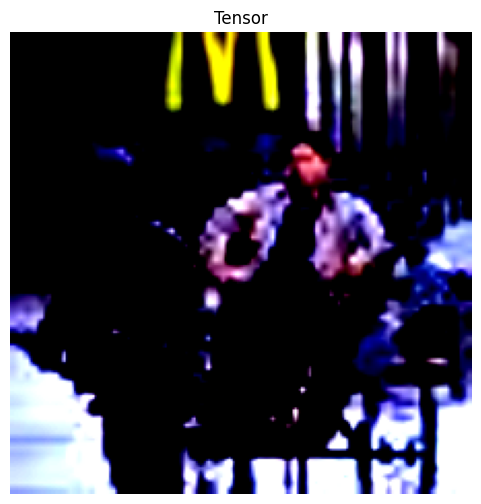

In [62]:
visualize_tensor(first_run_batches[0][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.552854].


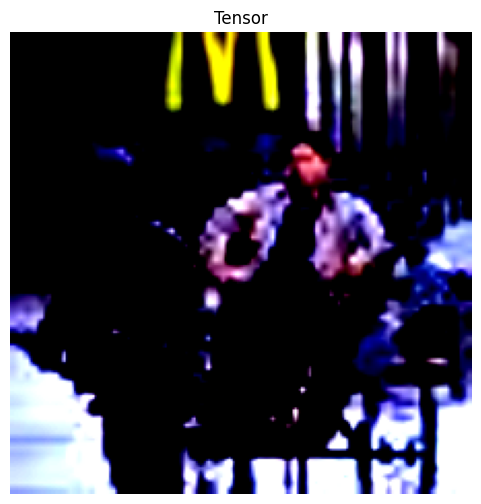

In [63]:
visualize_tensor(second_run_batches[0][0])

### Visualize env

### PPO agent training

In [97]:
rl_num_envs = 1
rl_batch_size = 4
rl_num_steps = rl_batch_size * rl_num_envs * 4


for i, batch in enumerate(tiny_imagenet_train_loader):
    for j in range(batch_size):
        env.env_method("set_img",
                       batch[j],
                       indices=j)
        
    break
    # env.learn(total_timesteps=rl_num_steps, progress_bar=False, log_interval=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


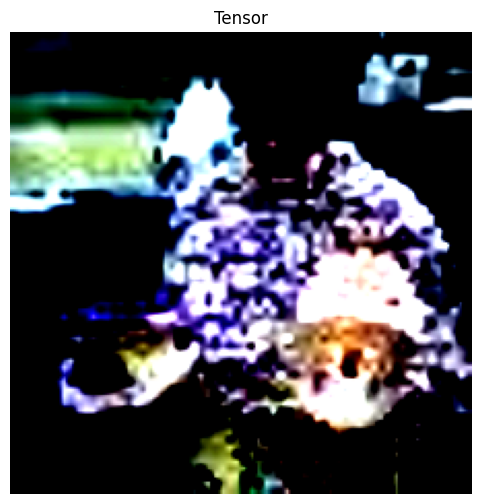

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


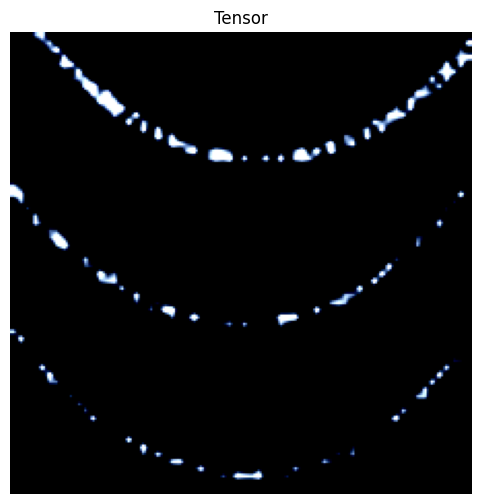

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


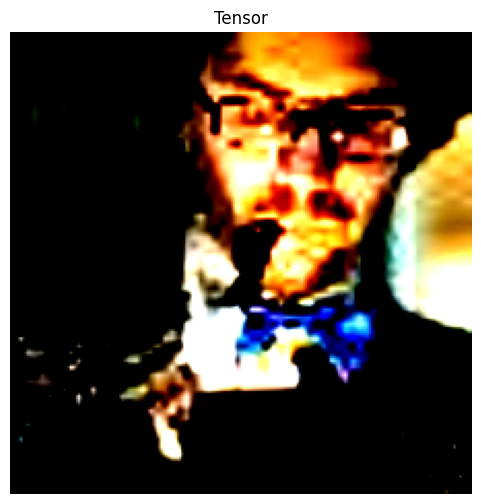

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


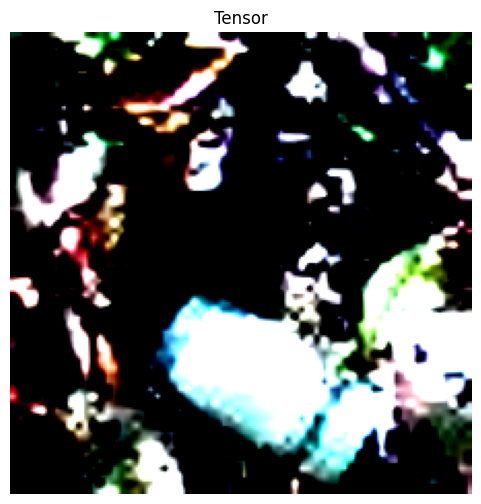

In [98]:
for i in range(BATCH_SIZE):
  visualize_tensor(env.get_attr("img", i)[0])

In [74]:

# test_env = ImageExplorationEnv(dummy_batch[0], env_config)
obs = env.reset()
num_eval_steps = 30

resnet_rl_model.predict(obs)

for step in range(num_eval_steps):

    # obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated = env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

Step 1: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 2: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 3: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 4: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 5: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 6: Action=[2 2 4 4], Reward=[0.47507542 0.63837147 0.52018005 0.39465305]
Step 7: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 8: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 9: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 10: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 11: Action=[2 2 4 4], Reward=[0.48902035 0.6287931  0.4964288  0.3741003 ]
Step 12: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 13: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 14: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 15: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 16: Action=[2 2 4 4], Reward=[0.47339293 0.60185295 0.5079167  0.36441305]
Step 17: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 18: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
Step 19: Action=[2 2 4 4], Reward=[0. 0. 0. 0.]
S

In [75]:
for i, batch in enumerate(tiny_imagenet_train_loader):
    vec_env = resnet_rl_model.get_env()
    vec_env.env_method("set_img", batch[0])
    resnet_rl_model.learn(total_timesteps=4 * rl_num_steps, progress_bar=False)

    if i == 1:
        break

---------------------------
| time/              |    |
|    fps             | 6  |
|    iterations      | 1  |
|    time_elapsed    | 10 |
|    total_timesteps | 64 |
---------------------------


KeyboardInterrupt: 

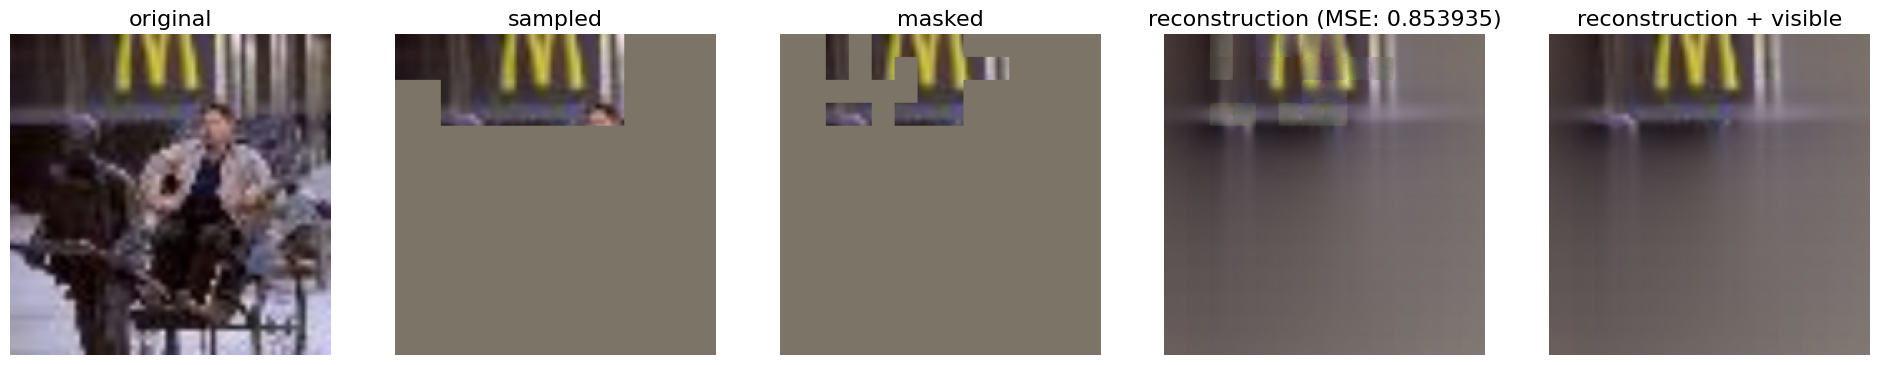

In [29]:
env = ImageExplorationEnv(dummy_batch[0], env_config)
env.reset()
# print(env._sensor_pos)
for _ in range(50):
    sample_action = env.action_space.sample()
    env.step(sample_action)
masked_sampled_img = env._reward_function.sampled_img_random_masking(env.sampled_img)
visualize_act_mae_reconstruction(env.img.unsqueeze(0), env.sampled_img.unsqueeze(0), masked_sampled_img.unsqueeze(0), mae_model)

In [30]:
env.reset()

({'sampled_img': array([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
  
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]],
        shape=(3, 224, 224), dtype=float32),
  'pos': array([[32, 64]], dtype=int32)},
 {})

In [61]:

# test_env = ImageExplorationEnv(env_config)
test_env = ImageExplorationEnv(env_config)


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=1, Reward=0.5078710913658142
Step 2: Action=1, Reward=0.0
Step 3: Action=1, Reward=0.0
Step 4: Action=1, Reward=0.0
Step 5: Action=1, Reward=0.0
Step 6: Action=1, Reward=0.5419400930404663
Step 7: Action=1, Reward=0.0
Step 8: Action=1, Reward=0.0
Step 9: Action=1, Reward=0.0
Step 10: Action=1, Reward=0.0
Step 11: Action=1, Reward=0.53711998462677
Step 12: Action=1, Reward=0.0
Step 13: Action=1, Reward=0.0
Step 14: Action=1, Reward=0.0
Step 15: Action=1, Reward=0.0
Step 16: Action=1, Reward=0.53711998462677
Step 17: Action=1, Reward=0.0
Step 18: Action=1, Reward=0.0
Step 19: Action=1, Reward=0.0
Step 20: Action=1, Reward=0.0
Step 21: Action=1, Reward=0.53711998462677
Step 22: Action=1, Reward=0.0
Step 23: Action=1, Reward=0.0
Step 24: Action=1, Reward=0.0
Step 25: Action=1, Reward=0.0
Step 26: Action=1, Reward=0.53711998462677
Step 27: Action=1, Reward=0.0
Step 28: Action=1, Reward=0.0
Step 29: Action=1, Reward=0.0
Step 30: Action=1, Reward=0.0


In [17]:

test_env = ImageExplorationEnv(env_config)


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=[[-0.03586613  0.04027002 -0.05291796]], Reward=0.2781301438808441
Step 2: Action=[[-0.03586795  0.04027075 -0.05291806]], Reward=0.0
Step 3: Action=[[-0.03586819  0.04027089 -0.05291942]], Reward=0.0
Step 4: Action=[[-0.03586914  0.04027038 -0.05291774]], Reward=0.0
Step 5: Action=[[-0.03587116  0.04026977 -0.05291591]], Reward=0.0
Step 6: Action=[[-0.03587161  0.04026836 -0.05291535]], Reward=0.2781301438808441
Step 7: Action=[[-0.0358715   0.04026932 -0.05291726]], Reward=0.0
Step 8: Action=[[-0.03586934  0.04027072 -0.05291487]], Reward=0.0
Step 9: Action=[[-0.03586895  0.04027113 -0.05291753]], Reward=0.0
Step 10: Action=[[-0.03586899  0.04027225 -0.05291666]], Reward=0.0
Step 11: Action=[[-0.03586674  0.04027217 -0.05291623]], Reward=0.2683430016040802
Step 12: Action=[[-0.03586898  0.0402725  -0.0529163 ]], Reward=0.0
Step 13: Action=[[-0.03586659  0.04027249 -0.05291585]], Reward=0.0
Step 14: Action=[[-0.03586786  0.04027218 -0.05291601]], Reward=0.0
Step 15: Act

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].


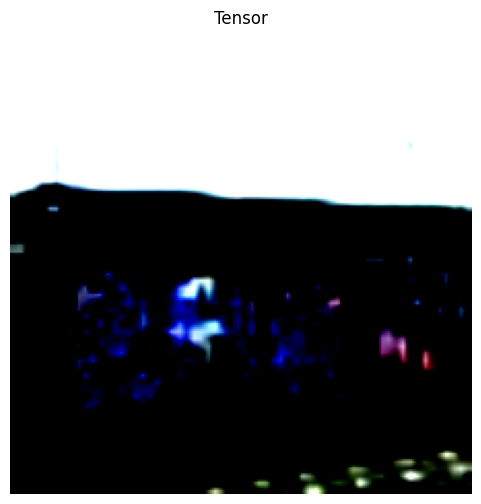

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6212862..0.3567756].


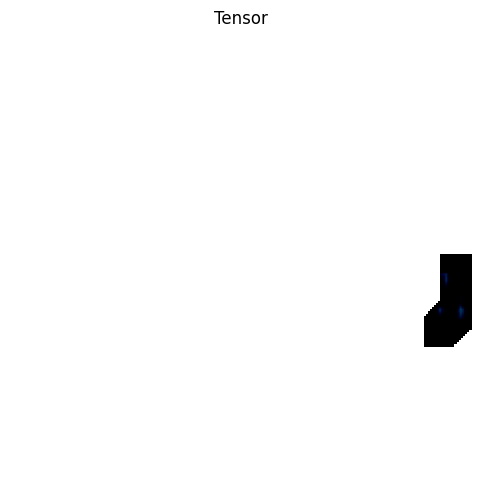

In [18]:
for i in range(test_env.batch_size):
    visualize_tensor(test_env.img[i])
    visualize_tensor(test_env.sampled_img[i])

In [32]:
env.action_space.sample()

np.int64(5)

In [36]:
vec_env = resnet_rl_model.get_env()

In [38]:
vec_env.action_space.sample()

np.int64(3)

In [39]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
evaluate_policy